<a href="https://colab.research.google.com/github/liamrogers03/COMP90054/blob/main/problem_set_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP90054 AI Planning for Autonomy
### Problem Set 03
 - Choosing Heuristics - solution




### Key concepts:
- Heuristic Functions and their properties and relations
- Heuristic search algorithms
- State-space model and size of the problem


### Set up the environment:
- Please run the following blocks of code to initialise the *environment*

In [1]:
!pip install pydotplus

In [5]:
import numpy as np
import pydotplus
from IPython.display import display, Image
from ipywidgets import interact
import heapq
import matplotlib.pyplot as plt
import functools
import copy

In [7]:
# Class of the problem
class Problem():
  initial_state = None
  state_space = None
  goal_states = None
  actions = None
  transition_function = None
  costs = None

  def __init__(self, initial_state, state_space, goal_states, actions, transition_function, costs):
    self.initial_state = initial_state
    self.state_space = state_space
    self.goal_states = goal_states
    self.actions = actions
    self.transition_function = transition_function
    self.costs = costs
    self.current_state = self.initial_state
    return

  def printStateSpace(self):
    print ('initial_state={}'.format(self.initial_state))
    print ('state_space={}'.format(self.state_space))
    print ('goal_states={}'.format(self.goal_states))
    print ('actions={}'.format(self.actions))
    print ('transition_function={}'.format(self.transition_function))
    print ('costs={}'.format(self.costs))

class GridProblem(Problem):

  def __init__(self,grid):

    # generate states:
    states = []
    for g in powerset(grid.g_pos):
      for i in range(grid.width):
        for j in range(grid.height):
          if not (i,j) in g:
            states.append(((i,j),frozenset(g)))

    self.state_space = set(states)

    # generate initial state
    self.initial_state = (grid.start_pos, frozenset(grid.g_pos.difference({grid.start_pos})))

    # generate goal state
    self.goal_states = set([((i,j),frozenset()) for i in range(grid.width) for j in range(grid.height)])

    # generate actions
    self.actions = {s: set(grid.generateActions(s)) for s in self.state_space}
    for s in self.state_space:
      if grid.isGoal(s):
        self.actions.update({s:{}})

    self.transition_function = {}
    for s in self.state_space:
      for a in self.actions[s]:
        self.transition_function.update({(s,a):grid.generatedSuccessor(s,a)})

    self.costs = { k:1 for k in self.transition_function.keys()}
    return None


# class of the grid
class Grid():
  width = None
  height = None
  walls = None
  start_pos = None
  g_pos = None

  def __init__(self, width,height,walls,start_pos,g_pos):
    self.width = width
    self.height = height
    self.walls = walls
    self.start_pos = start_pos
    self.g_pos = g_pos

  def generateActions(self,state):
    pos,_ = state
    x,y = pos
    actions = []
    for dx,dy in [(0,1),(0,-1),(1,0),(-1,0)]:
      x1 = x+dx
      y1 = y+dy
      if (not (x1,y1) in self.walls) and (x1>=0) and (x1<self.width) and (y1>=0) and (y1<self.height):
          actions.append((dx,dy))

    return actions

  def generatedSuccessor(self,state,action):
    pos,r_g_pos = state
    r_g_pos1 = set(r_g_pos.copy())
    x1 = pos[0]+action[0]
    y1 = pos[1]+action[1]
    if (x1,y1) in r_g_pos:
      r_g_pos1.remove((x1,y1))
    return ((x1,y1),frozenset(r_g_pos1))

  def isGoal(self,state):
    return state[1] == {}

  def printGrid(self):
    output = [['_' for i in range(self.width)] for j in range(self.height)]
    for x,y in self.walls:
      output[self.height-1-y][x] = 'W'
    output[self.height-1-self.start_pos[1]][self.start_pos[0]] = 's'
    for x,y in self.g_pos:
      output[self.height-1-y][x] = 'O'
    # for line in output:
    #   print(line)
    return output

  def printState(self,state):
    pos,g_pos = state
    output = [['_' for i in range(self.width)] for j in range(self.height)]
    for x,y in self.walls:
      output[self.height-1-y][x] = 'W'
    output[self.height-1-pos[1]][pos[0]] = 'a'
    for x,y in self.g_pos:
      output[self.height-1-y][x] = 'O'
    for x,y in self.g_pos:
      if not (x,y) in g_pos:
        output[self.height-1-y][x] = 'X'
    # for line in output:
    #   print(line)
    return output

  def printStateAction(self,state,action):
    pos,g_pos = state
    astr = {(0,1):'au2',(0,-1):'ad2',(-1,0): 'al2',(1,0): 'ar2'}

    output = [['_' for i in range(self.width)] for j in range(self.height)]
    for x,y in self.walls:
      output[self.height-1-y][x] = 'W'
    output[self.height-1-pos[1]][pos[0]] = 'a'
    for x,y in self.g_pos:
      output[self.height-1-y][x] = 'O'
    for x,y in self.g_pos:
      if not (x,y) in g_pos:
        output[self.height-1-y][x] = 'X'
    output[self.height-1-pos[1]][pos[0]] = astr[(action[0],action[1])]

    # for line in output:
    #   print(line)
    return output

def powerset(lst):
    return functools.reduce(lambda result, x: result + [subset + [x] for subset in result],
                  lst, [[]])

def calculateHstar(problem,heuristic):
  hstar = {}
  h0 = {state:0 for state in problem.state_space}
  for state in problem.state_space:
    current_node = (state, int(heuristic[state]), 0, None, [])
    hstar.update({state :len(astar(problem,heuristic,current_node)[0])})
  return hstar

def astar(problem, heuristic, start_node):
  expansion_order = []
  pq = PriorityQueue()
  pq.push(start_node,int(heuristic[problem.initial_state]))

  while not pq.isEmpty():
    current_node = pq.pop()
    expansion_order.append(current_node)
    state, fn, accu_cost, parent_node_id, actions = current_node

    # Goal Check
    if state in problem.goal_states:
      return (actions,expansion_order)

    # Add successor nodes into queue (no loop check; randomly tie-break)
    for action in problem.actions[state]:
      succ_state = problem.transition_function[(state, action)]
      cost = accu_cost + problem.costs[(state, action)]
      pq.push((succ_state, int(heuristic[succ_state])+cost ,cost, len(expansion_order)-1,actions+[action]),int(heuristic[succ_state])+cost)

  return (None,expansion_order)

def vis_grid(grid_matrix,transition_list):
  arrows = {(-1,0):np.array([0, -1]),
      (0,1):np.array([-1, 0]),
      (1,0):np.array([0, 1]),
      (0,-1):np.array([1, 0])}
  arraw_size = 0.6
  len_lim = 4

  height = len(grid_matrix)
  width = len(grid_matrix[0])
  plt.gcf().set_size_inches(width, height)
  xticks = np.linspace(0,width,width+1)
  yticks = np.linspace(0,height,height+1)
  plt.xticks(xticks)
  plt.yticks(yticks)
  plt.xlim(0, width)
  plt.ylim(0, height)

  for i in range(height):
    for j in range(width):
      t = grid_matrix[i][j]
      #print (t)
      if type(t) is not str:
        plt.text(j+0.5,height-1-i+0.5,str(t)[:4],fontsize=30,horizontalalignment='center',verticalalignment='center')
      else:
        if t == '_':
          continue
        plt.text(j+0.5,height-1-i+0.5,t,fontsize=40,horizontalalignment='center',verticalalignment='center')
  for transition in transition_list:
    pos,t = transition
    i,j = pos
    a = arrows[t] * arraw_size/2
    plt.arrow(i+0.5+a[1]/2,j+0.5-a[0]/2,a[1]*2,-a[0]*2,head_width=0.15, head_length=0.1, fc='k', ec='k')
  plt.grid(True)
# vis_grid(grid.printGrid())

class PriorityQueue:
    """
      Implements a priority queue data structure. Each inserted item
      has a priority associated with it and the client is usually interested
      in quick retrieval of the lowest-priority item in the queue. This
      data structure allows O(1) access to the lowest-priority item.
    """
    def  __init__(self):
        self.heap = []
        self.count = 0

    def push(self, item, priority):
        entry = (priority, self.count, item)
        heapq.heappush(self.heap, entry)
        self.count += 1

    def pop(self):
        (_, _, item) = heapq.heappop(self.heap)
        return item

    def isEmpty(self):
        return len(self.heap) == 0

    def update(self, item, priority):
        # If item already in priority queue with higher priority, update its priority and rebuild the heap.
        # If item already in priority queue with equal or lower priority, do nothing.
        # If item not in priority queue, do the same thing as self.push.
        for index, (p, c, i) in enumerate(self.heap):
            if i == item:
                if p <= priority:
                    break
                del self.heap[index]
                self.heap.append((priority, c, item))
                heapq.heapify(self.heap)
                break
        else:
            self.push(item, priority)

# Helper function to visualize the problem (i.e. draw state transition graph)
def generate_state_graph(problem,heuristics):
  state_graph={}
  state_graph['nodes'] = {k:{'label':'\"{}\n{}\"'.format(k,heuristics[k])} for k in sorted(list(problem.state_space))}
  state_graph['nodes'][problem.initial_state]['color'] = 'green'
  for goal in problem.goal_states:
      state_graph['nodes'][goal]['shape'] = 'doublecircle'
  state_graph['edge'] = {(s,problem.transition_function[(s,a)]):{'label':f'"{a}"'} for (s,a) in problem.costs.keys()}
  return state_graph

def render_graph(param):
  s = ''
  s += 'digraph G { \n'

  for node,tdict in param['nodes'].items():
    tstr = f'"{node}"' + ' '
    if bool(tdict):
      tstr += '['
      for k,v in tdict.items():
        tstr += '{}={},'.format(k,v)
      tstr = tstr[:-1] + ']'
    tstr += ';\n'
    s+=tstr

  for edge,tdict in param['edge'].items():
    tstr = f'"{edge[0]}"->"{edge[1]}" '
    # tstr = str(edge[0]) + '->' + str(edge[1]) + ' '
    if bool(tdict):
      tstr += '['
      for k,v in tdict.items():
        tstr += '{}={},'.format(k,v)
      tstr = tstr[:-1] + ']'
    tstr += ';\n'
    s+=tstr
  s += ' \n}'

  # print (s)
  graph = pydotplus.graph_from_dot_data(s)
  return graph.create_png()


# Visualize the search process (not required)
def visualize_heuristic_search_process(nodes,problem):
    progress = []

    for i,(state,fn,value,parent) in enumerate(nodes):
        param = {}
        param['nodes'] = {str(k):{'label':'\"n{}\n{},{},{},{}\"'.format(k,state,fn,cost,parent)} for k,(state,fn,cost,parent) in enumerate(nodes[:i+1])}

        # The newly generated node is red while all other nodes are green
        for k in param['nodes']:
            param['nodes'][k]['color'] = 'green'
        param['nodes'][str(i)]['color'] = 'red'

        # Black edges
        param['edge'] = {(str(parent), str(k)): {'label': str(problem.costs[(nodes[parent][0], state)])} for k, (state,fn, cost, parent) in enumerate(nodes[:i+1]) if not parent is None}
        for edge in param['edge']:
            param['edge'][edge]['color'] = 'black'

        progress.append(param)

    prog_imgs = [render_graph(param) for param in progress]
    def show_img(idx):
        return display(Image(prog_imgs[idx]))
    interact(show_img,idx=(0,len(prog_imgs)-1,1))







---



### Review and Recap

Consider a $m \times m$ manhattan grid,
and a set of coordinates $G'$ to visit in any order, and a set of inaccessible coordinates (walls) $W$. A state-space model can be represented as $P = \langle S,s_0, S_G, A, T,c \rangle$, where:
> We use $G'$ instead of $G$, becasue charactor $G$ is used in STRIPS model ($P= \langle F,O,I,G \rangle $).

*    $S = \{ \langle x , y, V' \rangle \mid x, y \in \{0,\dots,m-1\} \, \land \, V' \subseteq G' \}$

*    $s_0 = \langle (0,0),V \setminus \{(0,0)\} \rangle$

*    $S_G = \{ \langle (x,y),\{\} \rangle \mid x,y \in \{0,\dots,m-1\} \}$

*    $A(\langle x , y, V' \rangle) = \{ \left( dx , dy \right) \mid $
  
   *   $ dx, dy \in \{-1, 0, 1\} $
   *   $\land \ |dx| + |dy| = 1 $
   *   $\land \ x + dx, y + dy \in \{0,\dots,m-1\}$
   *   $(x+dx,y+dy) \notin W \ \} $

*    $T(\langle x , y, V' \rangle,\left(dx, dy\right)) = \langle x+dx , y+dy, V' \setminus \{(x+dx, y+dy)\} \rangle $

*    $c(a, s) = 1$


### Simple Grid Example:

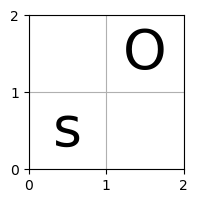

In [9]:
width0 = 2
height0 = 2
walls0 = {}
start_pos0 = (0,0)
g_pos0 = {(1,1)}

grid0 = Grid(width0,height0,walls0,start_pos0,g_pos0)
vis_grid(grid0.printGrid(),{})

Code to auto generate state space model for the Manhattan Grid Problem:

In [12]:
problem0 = GridProblem(grid0)
problem0.printStateSpace()
heuristics_customised = {s:0 for s in problem0.state_space}

initial_state=((0, 0), frozenset({(1, 1)}))
state_space={((1, 0), frozenset()), ((1, 0), frozenset({(1, 1)})), ((0, 0), frozenset({(1, 1)})), ((1, 1), frozenset()), ((0, 0), frozenset()), ((0, 1), frozenset({(1, 1)})), ((0, 1), frozenset())}
goal_states={((1, 0), frozenset()), ((0, 1), frozenset()), ((1, 1), frozenset()), ((0, 0), frozenset())}
actions={((1, 0), frozenset()): {(0, 1), (-1, 0)}, ((1, 0), frozenset({(1, 1)})): {(0, 1), (-1, 0)}, ((0, 0), frozenset({(1, 1)})): {(0, 1), (1, 0)}, ((1, 1), frozenset()): {(-1, 0), (0, -1)}, ((0, 0), frozenset()): {(0, 1), (1, 0)}, ((0, 1), frozenset({(1, 1)})): {(1, 0), (0, -1)}, ((0, 1), frozenset()): {(1, 0), (0, -1)}}
transition_function={(((1, 0), frozenset()), (0, 1)): ((1, 1), frozenset()), (((1, 0), frozenset()), (-1, 0)): ((0, 0), frozenset()), (((1, 0), frozenset({(1, 1)})), (0, 1)): ((1, 1), frozenset()), (((1, 0), frozenset({(1, 1)})), (-1, 0)): ((0, 0), frozenset({(1, 1)})), (((0, 0), frozenset({(1, 1)})), (0, 1)): ((0, 1), frozen

Code to visualize the state transition graph (please do not try this with large state-space)

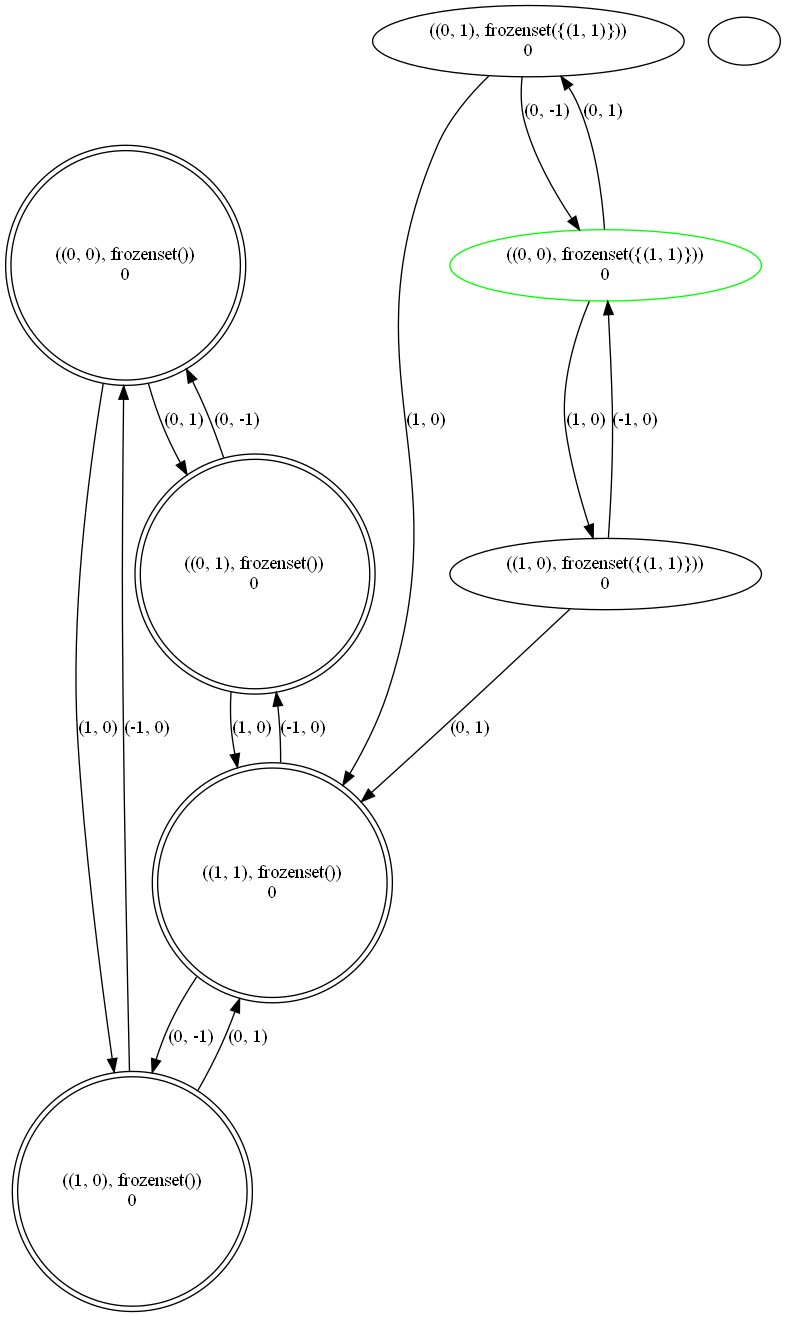

In [19]:
display(Image(render_graph(generate_state_graph(problem0,heuristics_customised))))



---


### Problem 1:


Reformulate the state-space model from *Review and Recap* as a STRIPS problem $P= \langle F,O,I,G \rangle $, where:

F={}

O={}

I={}

G={}

### Problem 2:

Define the following heuristics for this problem, and discuss the admissibilty, consistency and domination relation for those heuristics (as well as the computational efficiency):

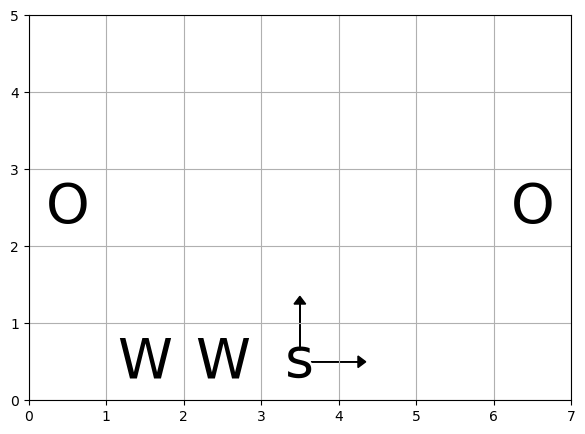

In [21]:
width = 7
height = 5
walls = {(1,0),(2,0)}
start_pos = (3,0)
g_pos = {(0,2),(6,2)}

grid = Grid(width,height,walls,start_pos,g_pos)
problem = GridProblem(grid)
transition_list = [(problem.initial_state[0],a) for a in grid.generateActions(problem.initial_state)]
vis_grid(grid.printGrid(),transition_list)

hstar={((2, 1), frozenset()): 0, ((5, 2), frozenset()): 0, ((3, 1), frozenset({(0, 2)})): 4, ((6, 2), frozenset({(0, 2)})): 6, ((2, 4), frozenset({(6, 2)})): 6, ((4, 3), frozenset()): 0, ((1, 3), frozenset({(0, 2), (6, 2)})): 8, ((3, 3), frozenset({(0, 2)})): 4, ((6, 4), frozenset({(0, 2)})): 8, ((5, 3), frozenset({(6, 2)})): 2, ((1, 2), frozenset()): 0, ((0, 0), frozenset({(6, 2)})): 8, ((5, 0), frozenset({(0, 2), (6, 2)})): 9, ((1, 4), frozenset()): 0, ((5, 3), frozenset()): 0, ((0, 2), frozenset({(6, 2)})): 6, ((6, 0), frozenset({(6, 2)})): 2, ((1, 1), frozenset({(0, 2), (6, 2)})): 8, ((5, 2), frozenset({(0, 2), (6, 2)})): 7, ((0, 1), frozenset({(0, 2)})): 1, ((6, 0), frozenset()): 0, ((2, 0), frozenset()): 0, ((2, 3), frozenset({(6, 2)})): 5, ((2, 2), frozenset()): 0, ((0, 3), frozenset({(6, 2)})): 7, ((5, 3), frozenset({(0, 2), (6, 2)})): 8, ((3, 2), frozenset({(0, 2)})): 3, ((0, 0), frozenset({(0, 2), (6, 2)})): 8, ((4, 0), frozenset({(0, 2)})): 6, ((3, 4), frozenset({(0, 2)})): 5, ((6, 0), frozenset({(0, 2), (6, 2)})): 8, ((4, 1), frozenset({(6, 2)})): 3, ((5, 4), frozenset({(6, 2)})): 3, ((0, 4), frozenset({(0, 2)})): 2, ((5, 4), frozenset()): 0, ((4, 1), frozenset({(0, 2)})): 5, ((6, 1), frozenset({(6, 2)})): 1, ((2, 3), frozenset({(0, 2), (6, 2)})): 9, ((3, 0), frozenset()): 0, ((6, 1), frozenset()): 0, ((4, 2), frozenset({(0, 2)})): 4, ((1, 3), frozenset()): 0, ((3, 1), frozenset({(6, 2)})): 4, ((5, 4), frozenset({(0, 2), (6, 2)})): 9, ((5, 1), frozenset()): 0, ((1, 1), frozenset()): 0, ((3, 3), frozenset({(6, 2)})): 4, ((4, 4), frozenset({(0, 2)})): 6, ((3, 1), frozenset()): 0, ((6, 4), frozenset({(6, 2)})): 2, ((3, 0), frozenset({(0, 2), (6, 2)})): 11, ((6, 1), frozenset({(0, 2), (6, 2)})): 7, ((6, 3), frozenset({(0, 2)})): 7, ((3, 3), frozenset()): 0, ((2, 4), frozenset()): 0, ((0, 1), frozenset({(6, 2)})): 7, ((5, 1), frozenset({(0, 2), (6, 2)})): 8, ((0, 0), frozenset()): 0, ((3, 1), frozenset({(0, 2), (6, 2)})): 10, ((0, 2), frozenset()): 0, ((3, 3), frozenset({(0, 2), (6, 2)})): 10, ((6, 4), frozenset({(0, 2), (6, 2)})): 8, ((3, 2), frozenset({(6, 2)})): 3, ((2, 4), frozenset({(0, 2), (6, 2)})): 10, ((4, 0), frozenset({(6, 2)})): 4, ((3, 4), frozenset({(6, 2)})): 5, ((3, 2), frozenset()): 0, ((2, 3), frozenset()): 0, ((0, 4), frozenset({(6, 2)})): 8, ((0, 3), frozenset()): 0, ((0, 1), frozenset({(0, 2), (6, 2)})): 7, ((3, 4), frozenset()): 0, ((4, 1), frozenset()): 0, ((5, 0), frozenset({(0, 2)})): 7, ((4, 2), frozenset({(6, 2)})): 2, ((3, 2), frozenset({(0, 2), (6, 2)})): 9, ((2, 1), frozenset({(0, 2)})): 3, ((5, 2), frozenset({(0, 2)})): 5, ((4, 2), frozenset()): 0, ((0, 3), frozenset({(0, 2), (6, 2)})): 7, ((3, 4), frozenset({(0, 2), (6, 2)})): 11, ((4, 3), frozenset({(0, 2)})): 5, ((4, 4), frozenset({(6, 2)})): 4, ((1, 2), frozenset({(0, 2)})): 1, ((4, 1), frozenset({(0, 2), (6, 2)})): 9, ((6, 3), frozenset({(6, 2)})): 1, ((1, 4), frozenset({(0, 2)})): 3, ((6, 2), frozenset()): 0, ((4, 2), frozenset({(0, 2), (6, 2)})): 8, ((6, 4), frozenset()): 0, ((2, 0), frozenset({(0, 2)})): 4, ((2, 2), frozenset({(0, 2)})): 2, ((4, 4), frozenset({(0, 2), (6, 2)})): 10, ((0, 1), frozenset()): 0, ((1, 0), frozenset({(0, 2)})): 3, ((6, 3), frozenset({(0, 2), (6, 2)})): 7, ((4, 0), frozenset()): 0, ((3, 0), frozenset({(0, 2)})): 5, ((5, 0), frozenset({(6, 2)})): 3, ((0, 4), frozenset()): 0, ((1, 3), frozenset({(0, 2)})): 2, ((2, 1), frozenset({(6, 2)})): 5, ((5, 2), frozenset({(6, 2)})): 1, ((5, 1), frozenset({(0, 2)})): 6, ((4, 3), frozenset({(6, 2)})): 3, ((1, 1), frozenset({(0, 2)})): 2, ((4, 0), frozenset({(0, 2), (6, 2)})): 10, ((1, 2), frozenset({(6, 2)})): 5, ((0, 4), frozenset({(0, 2), (6, 2)})): 8, ((1, 4), frozenset({(6, 2)})): 7, ((2, 4), frozenset({(0, 2)})): 4, ((4, 4), frozenset()): 0, ((5, 3), frozenset({(0, 2)})): 6, ((2, 1), frozenset({(0, 2), (6, 2)})): 9, ((0, 0), frozenset({(0, 2)})): 2, ((2, 0), frozenset({(6, 2)})): 6, ((6, 3), frozenset()): 0, ((6, 0), frozenset({(0, 2)})): 8, ((4, 3), frozenset({(0, 2), (6, 2)})): 9, ((2, 2), frozenset({(6, 2)})): 4, ((1, 2), frozenset({(0, 2), (6, 2)})): 7, ((1, 0), frozenset({(6, 2)})): 7, ((1, 4), frozenset({(0, 2), (6, 2)})): 9, ((2, 3), frozenset({(0, 2)})): 3, ((1, 0), frozenset()): 0, ((0, 3), frozenset({(0, 2)})): 1, ((2, 0), frozenset({(0, 2), (6, 2)})): 10, ((3, 0), frozenset({(6, 2)})): 5, ((5, 4), frozenset({(0, 2)})): 7, ((2, 2), frozenset({(0, 2), (6, 2)})): 8, ((1, 3), frozenset({(6, 2)})): 6, ((1, 0), frozenset({(0, 2), (6, 2)})): 9, ((6, 1), frozenset({(0, 2)})): 7, ((5, 1), frozenset({(6, 2)})): 2, ((1, 1), frozenset({(6, 2)})): 6, ((5, 0), frozenset()): 0}

#### Example heuristic

In [24]:
def zeroHeuristics(problem,grid):
  width = grid.width
  height = grid.height
  walls = grid.walls


  heuristic_dict = {}
  for state in problem.state_space:
    current_pos = state[0]
    current_g_pos = state[1]
    # Your code here
    # --------------------

    h_value = 0

    # --------------------
    heuristic_dict.update({state: h_value})

  return heuristic_dict

h0 = zeroHeuristics(problem,grid)

#### Goal-Counting heuristic:

In [26]:
def gcHeuristics(problem,grid):
  width = grid.width
  height = grid.height
  walls = grid.walls

  heuristic_dict = {}
  for state in problem.state_space:
    current_pos = state[0]
    current_g_pos = state[1]
    # Your code here
    # --------------------

    h_value = len(current_g_pos)

    # --------------------
    heuristic_dict.update({state: h_value})

  return heuristic_dict

gc = gcHeuristics(problem,grid)

#### Manhattan Distance to Closest Goal (positions) heuristic:

In [34]:
def mdcHeuristics(problem,grid):
  width = grid.width
  height = grid.height
  walls = grid.walls

  heuristic_dict = {}
  for state in problem.state_space:
    current_pos = state[0]
    current_g_pos = state[1]
    # Your code here
    # --------------------

    if len(current_g_pos) == 0:
        h_value = 0
    else:
        mh_dist = [abs(x - current_pos[0]) + abs(y - current_pos[1]) for x, y in current_g_pos]
        h_value = min(mh_dist)

    # --------------------
    heuristic_dict.update({state: h_value})

  return heuristic_dict

mdc = mdcHeuristics(problem,grid)

#### Manhattan Distance to Furthest Goal (positions) heuristic:

In [36]:
def mdfHeuristics(problem,grid):
  width = grid.width
  height = grid.height
  walls = grid.walls

  heuristic_dict = {}
  for state in problem.state_space:
    current_pos = state[0]
    current_g_pos = state[1]
    # Your code here
    # --------------------

    if len(current_g_pos) == 0:
        h_value = 0
    else:
        mh_dist = [abs(x - current_pos[0]) + abs(y - current_pos[1]) for x, y in current_g_pos]
        h_value = max(mh_dist)

    # --------------------
    heuristic_dict.update({state: h_value})

  return heuristic_dict

mdf = mdfHeuristics(problem,grid)


#### Any other heuristic you would like to try:

#### Check properties:
The following session is only for you to play around. If a heuristic passed the test, it **only** means it passed the test for this particular problem (layout). It **does not** mean it can pass all tests for different problem from the Mahattan Grid Domain, or in general.

##### Check admissibility:

In [38]:
heuristic_list = {'Zero Heuristic':h0,'Goal Counting Heuristic':gc,'Manhattan Distance to Closest goal Heuristic':mdc,'Manhattan Distance to Furthest goal Heuristic':mdf}

def checkA(problem, heuristic, hstar):
  for state in problem.state_space:
    if heuristic[state] > hstar[state]:
      return False
  return True

for label, h in heuristic_list.items():
  print(f"{label}'s admissibility on the problem:")
  print(checkA(problem,h, hstar))

Zero Heuristic's admissibility on the problem:
True
Goal Counting Heuristic's admissibility on the problem:
True
Manhattan Distance to Closest goal Heuristic's admissibility on the problem:
True
Manhattan Distance to Furthest goal Heuristic's admissibility on the problem:
True


##### Check consistency:

In [40]:

def check_consistency(problem,heuristic):
  for (state,action),state1 in problem.transition_function.items():
    if heuristic[state1]+problem.costs[(state,action)]< heuristic[state]:
      print('Inconsistent due to transition {} to {}. {} + {} is not larger or equal to {}.'.format( state, state1, problem.costs[(state,action)],int(heuristic[state1]),int(heuristic[state]) ))
      return False
  return True

for label, h in heuristic_list.items():
  print(f"{label}'s consistency:")
  print(check_consistency(problem,h))

Zero Heuristic's consistency:
True
Goal Counting Heuristic's consistency:
True
Manhattan Distance to Closest goal Heuristic's consistency:
True
Manhattan Distance to Furthest goal Heuristic's consistency:
True


##### Dominate relation:

In [42]:
checking_list = [(i,j) for i in heuristic_list.items() for j in heuristic_list.items() if i!=j]

def check_domination(h1,h2):
  for state in problem.state_space:
    if not int(h1[1][state]) >= int(h2[1][state]):
      # print(f'state is {state}, {h1[0]} h is {h1[1][state]} < {h2[0]} h is {h2[1][state]}')
      return False
  return True

for state in problem.state_space:
  for action in problem.actions[state]:
    pos,g_pos = problem.transition_function[(state,action)]
    if pos in g_pos:
      print(f"state: {state}, action: {action}, state': {pos,g_pos}")

# since all heuristics are admissible, so we can simply check biggness relation
for h1,h2 in checking_list:
  print(f'{h1[0]} dominates {h2[0]} is: {check_domination(h1,h2)}')

Zero Heuristic dominates Goal Counting Heuristic is: False
Zero Heuristic dominates Manhattan Distance to Closest goal Heuristic is: False
Zero Heuristic dominates Manhattan Distance to Furthest goal Heuristic is: False
Goal Counting Heuristic dominates Zero Heuristic is: True
Goal Counting Heuristic dominates Manhattan Distance to Closest goal Heuristic is: False
Goal Counting Heuristic dominates Manhattan Distance to Furthest goal Heuristic is: False
Manhattan Distance to Closest goal Heuristic dominates Zero Heuristic is: True
Manhattan Distance to Closest goal Heuristic dominates Goal Counting Heuristic is: False
Manhattan Distance to Closest goal Heuristic dominates Manhattan Distance to Furthest goal Heuristic is: False
Manhattan Distance to Furthest goal Heuristic dominates Zero Heuristic is: True
Manhattan Distance to Furthest goal Heuristic dominates Goal Counting Heuristic is: True
Manhattan Distance to Furthest goal Heuristic dominates Manhattan Distance to Closest goal Heur

##### Compare the solution length and node expansion number with A*:

In [44]:
for label, h in heuristic_list.items():
  start_node = (problem.initial_state, int(h[problem.initial_state]), 0, None, [])
  l,n = astar(problem,h,start_node)
  print(f"{label} solution length: {len(l)}; number of node expansion: {len(n)}")

Zero Heuristic solution length: 11; number of node expansion: 262241
Goal Counting Heuristic solution length: 11; number of node expansion: 80835
Manhattan Distance to Closest goal Heuristic solution length: 11; number of node expansion: 68238
Manhattan Distance to Furthest goal Heuristic solution length: 11; number of node expansion: 4298
